# COADD CALEXPS

In [1]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
import itertools
%matplotlib inline

# Rubin TAP service utilities
import lsst.geom as geom
import lsst.afw.display as afwDisplay  # for image visualization
import lsst.afw.table as afwTable
from lsst.daf.butler import Butler # access to LSST data products
import lsst.daf.base as dafBase
afwDisplay.setDefaultBackend('matplotlib')

# pipeline tasks 
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.meas.algorithms import SourceDetectionTask, SourceDetectionConfig

import warnings
from astropy.units import UnitsWarning
warnings.simplefilter("ignore", category=UnitsWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'
butler = Butler(repo, collections=collection)

## to see the repos created in u/alrakomala/

In [15]:
!butler query-collections dp01 --chains=tree u/alrakomala/*

                             Name                                 Type   
------------------------------------------------------------- -----------
u/alrakomala/output_testKA                                    CHAINED    
  u/alrakomala/output_testKA/20220502T230407Z                 RUN        
  u/alrakomala/output_testKA/20220502T223657Z                 RUN        
  u/alrakomala/output_testKA/20220502T205525Z                 RUN        
  2.2i/raw/test-med-1                                         TAGGED     
  2.2i/calib/PREOPS-301                                       CALIBRATION
  2.2i/calib/gen2                                             CALIBRATION
  2.2i/calib/PREOPS-301/unbounded                             RUN        
  skymaps                                                     RUN        
  refcats/PREOPS-301                                          RUN        
u/alrakomala/output_testKA/20220502T205525Z                   RUN        
u/alrakomala/output_testKA/20220502T22

In [18]:
##butler collection-chain dp01 –remove u/alrakomala/output_testKA u/alrakomala/output_testKA/20220502T230407Z

# to remove CHAINED
#butler remove-collections dp01 u/alrakomala/coadding_tests
# then the RUN: 
#butler remove-runs dp01 u/alrakomala/coadding_tests/20220527T184028Z

[u/alrakomala/output_testKA, u/alrakomala/output_testKA/20220502T230407Z]


## From natelust recommendation (community forum)

https://community.lsst.org/t/coadding-dp0-calexps-from-different-detectors-for-the-same-deepcoadd/6436/7

example using SimplePipelineExecutor:
https://community.lsst.org/t/figuring-out-how-to-call-the-python-api/6432/11

In [14]:
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline

repo = 's3://butler-us-central1-dp01'
collection = ['2.2i/runs/DP0.1']
constrains = "band = 'g' AND skymap = 'DC2' AND tract = 4638 AND visit in (633729, 633730, 183811, 633732, 400389)"

## FIRST MAKE WARPING 
yaml_file = '${PIPE_TASKS_DIR}/pipelines/DRP.yaml#makeWarp'

butler = SimplePipelineExecutor.prep_butler(repo, inputs=collection, output="u/alrakomala/coadding_tests")
spe = SimplePipelineExecutor.from_pipeline_filename(yaml_file, where=constrains, butler=butler)
quanta = spe.run(True)

In [14]:
## THEN COADD
yaml_coadd = '${PIPE_TASKS_DIR}/pipelines/DRP.yaml#assembleCoadd'
collection = ['2.2i/runs/DP0.1']
#collection_warp = ['u/alrakomala/coadding_tests']
constrains = "band = 'g' AND skymap = 'DC2' AND tract = 4638 AND visit in (633729, 633730, 183811, 633732, 400389)"

butler = SimplePipelineExecutor.prep_butler(repo, inputs=collection, output='u/alrakomala/coadding_tests/coadd_results1')
spe = SimplePipelineExecutor.from_pipeline_filename(yaml_coadd, where=constrains, butler=butler)
quanta = spe.run(True)

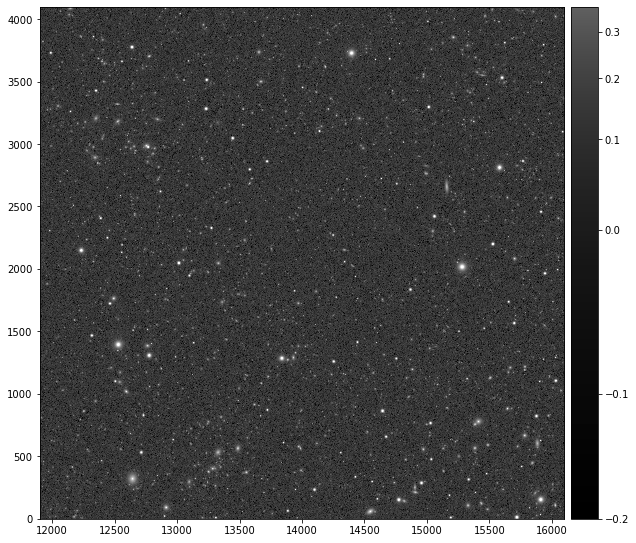

In [16]:
repo = 's3://butler-us-central1-dp01'
collection_me = 'u/alrakomala/coadding_tests/coadd_results1'
butler_me = Butler(repo, collections = collection_me)

dataId_me = {'tract': 4639, 'patch': 3, 'band': 'i'}
coadd_me = butler.get('deepCoadd_calexp', **dataId_me)

fig, ax = plt.subplots(figsize =(10,10))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
#display.scale('linear', 'zscale')
display.mtv(coadd_me.image)
plt.show()


In [18]:
registry = butler_me.registry
datasetRefs = registry.queryDatasets(datasetType='calexp', collections=collection_me)

for i, ref in enumerate(datasetRefs):
    print(ref.dataId.full)
    print(ref.dataId)
    print(ref.dataId['band'])
    print(' ')
    if i > 4:
        break

{band: 'r', instrument: 'LSSTCam-imSim', detector: 115, physical_filter: 'r_sim_1.4', visit_system: 1, visit: 733724}
{instrument: 'LSSTCam-imSim', detector: 115, visit: 733724, ...}
r
 
{band: 'r', instrument: 'LSSTCam-imSim', detector: 112, physical_filter: 'r_sim_1.4', visit_system: 1, visit: 733724}
{instrument: 'LSSTCam-imSim', detector: 112, visit: 733724, ...}
r
 
{band: 'r', instrument: 'LSSTCam-imSim', detector: 108, physical_filter: 'r_sim_1.4', visit_system: 1, visit: 733724}
{instrument: 'LSSTCam-imSim', detector: 108, visit: 733724, ...}
r
 
{band: 'r', instrument: 'LSSTCam-imSim', detector: 109, physical_filter: 'r_sim_1.4', visit_system: 1, visit: 733724}
{instrument: 'LSSTCam-imSim', detector: 109, visit: 733724, ...}
r
 
